In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv


# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [4]:
items_raw_df = pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part1.csv')
items_raw1_df = pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part2.csv')
items_raw_df = pd.concat([items_raw_df, items_raw1_df])
events_raw_df = pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')

In [5]:
print("shape of items raw dataframe is ",items_raw_df.shape)

shape of items raw dataframe is  (20275902, 4)


In [6]:
print("shape of events raw dataframe is ",events_raw_df.shape)

shape of events raw dataframe is  (2756101, 5)


## EDA for items

In [7]:
items_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [8]:
items_raw_df.head(5)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [9]:
print(
    f"""
    There are {items_raw_df['itemid'].nunique()} distinct items.
    There are {items_raw_df['property'].nunique()} distinct properties.
    """)


    There are 417053 distinct items.
    There are 1104 distinct properties.
    


In [10]:
print("we have ",round((items_raw_df['itemid'].nunique()*100)/items_raw_df.shape[0],2),"percent unique items")

we have  2.06 percent unique items


Having 2cr items makes it difficult to run the system on notebook hence we will only use a subset of it

In [11]:
np.random.seed(1)
items_to_keep = np.random.choice(items_raw_df['itemid'].unique(), size=100000, replace=False)
items_df = items_raw_df[items_raw_df['itemid'].isin(items_to_keep)]

In [12]:
items_df.shape

(4857423, 4)

In [13]:
print(
    f"""
    There are {items_df['itemid'].nunique()} distinct items.
    There are {items_df['property'].nunique()} distinct properties.
    """)


    There are 100000 distinct items.
    There are 1082 distinct properties.
    


taking the latest value according to time

In [14]:
items_df = items_df.groupby(['itemid', 'property'])['value'].last().to_frame().reset_index()
items_df.head()

,itemid,property,value
0,3,1025,769062
1,3,1080,769062
2,3,112,679677
3,3,159,519769
4,3,202,261419


In [15]:
items_df.shape

(2879857, 3)

# EDA for events

In [16]:
events_raw_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [17]:
events_raw_df.shape

(2756101, 5)

In [18]:
events_df = events_raw_df[events_raw_df['itemid'].isin(items_to_keep)]
events_df = events_df.sort_values(['visitorid', 'timestamp']).reset_index(drop=True)

In [19]:
events_raw_df.shape

(2756101, 5)

In [20]:
print(
    f"""
    There are {events_df['visitorid'].nunique()} distinct users in events.
    There are {events_df['transactionid'].nunique()} distinct transactions in events.
    There are {events_df['itemid'].nunique()} distinct items in events.
    The actions user can do are {events_df['event'].unique()}.
    """
)


    There are 375331 distinct users in events.
    There are 4995 distinct transactions in events.
    There are 44358 distinct items in events.
    The actions user can do are ['view' 'addtocart' 'transaction'].
    


In [21]:
print("percentage of unique users are ",round((events_df['visitorid'].nunique()/events_df['visitorid'].shape[0])*100,2))

percentage of unique users are  61.88


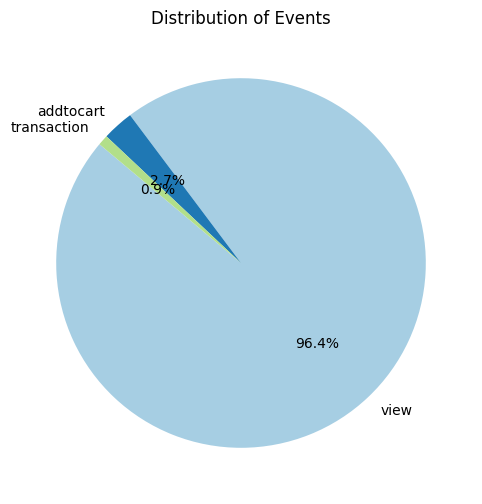

In [22]:
import matplotlib.pyplot as plt

# Count occurrences of each event type
event_counts = events_df['event'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Events")
plt.show()

## User Activity

In [23]:
events_df['visitorid'].value_counts()

visitorid
1150086    1722
530559      904
152963      737
895999      639
163561      594
           ... 
531737        1
531732        1
531729        1
531725        1
531757        1
Name: count, Length: 375331, dtype: int64

In [24]:
events_df['visitorid'].value_counts().describe()

count    375331.000000
mean          1.616104
std           5.738054
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1722.000000
Name: count, dtype: float64

## Item History

In [25]:
events_df['itemid'].value_counts()

itemid
257040    1647
96924     1633
234255    1307
151444    1230
9877      1162
          ... 
252427       1
345348       1
235263       1
26950        1
338168       1
Name: count, Length: 44358, dtype: int64

In [26]:
events_df['itemid'].value_counts().describe()

count    44358.000000
mean        13.674512
std         40.148043
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max       1647.000000
Name: count, dtype: float64

Implicit meachnism to rate the items 

In [27]:
events_df['rating'] = events_df['event'].map({'transaction': 5, 'addtocart': 4, 'view': 3})

In [28]:
events_df.drop(['transactionid'],axis=1,inplace=True)

In [29]:
events_df

,timestamp,visitorid,event,itemid,rating
0,1438970212664,2,view,259884,3
1,1438413035296,3,view,385090,3
2,1438713029611,10,view,248766,3
3,1430668212744,12,view,70225,3
4,1434602595136,13,view,278689,3
...,...,...,...,...,...
606569,1431311689814,1407572,view,122041,3
606570,1431738322384,1407572,view,122041,3
606571,1437973678632,1407573,view,116453,3
606572,1437973995037,1407573,view,57720,3


In [30]:
events_df['rating'].value_counts()

rating
3    584488
4     16598
5      5488
Name: count, dtype: int64

# Content Based Recommender System

## Feature Extraction for Items

In [31]:
items_df = items_df.groupby('itemid')['value'].apply(lambda x: ' '.join(x)).to_frame()

In [32]:
items_df

,value
itemid,
3,769062 769062 679677 519769 261419 1305767 300...
7,679677 519769 n156.000 350726 1318567 296357 6...
10,679677 519769 105592 339009 754794 243464 2434...
19,n399.360 357845 903043 769062 679677 519769 11...
32,726612 1116693 n973.200 424566 679677 519769 3...
...,...
466851,525705 679677 519769 140639 583616 1115994 823...
466853,679677 519769 1297729 n36.000 350726 30603 832...
466855,769062 n2640.000 1128577 246164 679677 519769 ...


In [33]:
tfidfvec = TfidfVectorizer(min_df=500, max_df=0.7)
vectorized_data = tfidfvec.fit_transform(items_df['value'])

In [34]:
tfidf_df = pd.DataFrame(vectorized_data.toarray(),
                       columns=tfidfvec.get_feature_names_out())
tfidf_df.index = items_df.index
display(tfidf_df)

,1000087,1001974,1002405,1007,1007882,1010547,1010870,1011636,101489,1015535,...,n7800,n84,n840,n8400,n900,n9000,n9216,n96,n960,n9600
itemid,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.223251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466851,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466853,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466855,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## User Profile

In [35]:
events_df.head()

,timestamp,visitorid,event,itemid,rating
0,1438970212664,2,view,259884,3
1,1438413035296,3,view,385090,3
2,1438713029611,10,view,248766,3
3,1430668212744,12,view,70225,3
4,1434602595136,13,view,278689,3


In [36]:
events_df.groupby('visitorid')['itemid'].nunique().sort_values(ascending=False)

visitorid
1150086    809
530559     432
895999     432
152963     374
892013     365
          ... 
498561       1
498559       1
498557       1
498556       1
498589       1
Name: itemid, Length: 375331, dtype: int64

In [37]:
events_df.groupby('visitorid')['itemid'].nunique().describe()

count    375331.000000
mean          1.240084
std           3.097060
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         809.000000
Name: itemid, dtype: float64

In [38]:
user_item_max_rating = events_df.groupby(['visitorid', 'itemid'])['rating'].max().reset_index()
user_item_max_rating.head()

,visitorid,itemid,rating
0,2,259884,3
1,3,385090,3
2,10,248766,3
3,12,70225,3
4,13,278689,3


In [39]:
user_item_max_rating['visitorid'].nunique()

375331

In [40]:
user_item_max_rating.shape

(465442, 3)

In [41]:
import pandas as pd
import numpy as np

# Sort the data by visitorid and timestamp (assuming you have a timestamp column)
# If you don't have a timestamp, you can use the index or any other ordering method
sorted_data = user_item_max_rating.sort_values(['visitorid'])

# Get the first occurrence of each visitorid
first_occurrences = sorted_data.groupby('visitorid').first().reset_index()

# Create initial training set with first occurrences of each visitor
train_data = first_occurrences.copy()

# Remove the first occurrences from the original data
remaining_data = sorted_data[~sorted_data.index.isin(first_occurrences.index)]

# If we have more than 1000 samples remaining, select 1000 for test
if len(remaining_data) > 1000:
    # Randomly select 1000 samples for test
    test_data = remaining_data.sample(n=1000, random_state=42)
    
    # Remove test data from remaining data
    remaining_after_test = remaining_data[~remaining_data.index.isin(test_data.index)]
    
    # Add only 10000 samples back to training (or all if less than 10000)
    samples_to_add = min(10000, len(remaining_after_test))
    additional_train = remaining_after_test.sample(n=samples_to_add, random_state=42)
    train_data = pd.concat([train_data, additional_train])
else:
    # If we have fewer than 1000 samples, use all remaining for test
    test_data = remaining_data

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print(f"Number of unique visitors in train: {train_data['visitorid'].nunique()}")
print(f"Number of unique visitors in test: {test_data['visitorid'].nunique()}")
print(f"All visitors in test also in train: {test_data['visitorid'].isin(train_data['visitorid']).all()}")

Train data shape: (385331, 3)
Test data shape: (1000, 3)
Number of unique visitors in train: 375331
Number of unique visitors in test: 977
All visitors in test also in train: True


In [42]:
tfidf_df.index = tfidf_df.index.astype(str)
train_data['itemid'] = train_data['itemid'].astype(str)

# Initialize an empty dictionary to store user vectors
user_vectors = {}

# Iterate over each user in the train data
for user_id, group in train_data.groupby('visitorid'):
    # Get the item IDs and ratings for the user
    item_ids = group['itemid'].values
    ratings = group['rating'].values
    
    # Get the item vectors for the items the user interacted with
    item_vectors = tfidf_df.loc[item_ids].values
    
    # Compute the weighted sum of item vectors
    weighted_sum = np.dot(ratings, item_vectors)
    
    # Normalize the user vector
    user_vector = normalize(weighted_sum.reshape(1, -1))  # L2 normalization
    user_vectors[user_id] = user_vector.flatten()

# Convert the user vectors dictionary to a DataFrame
user_vectors_df = pd.DataFrame.from_dict(user_vectors, orient='index', columns=tfidf_df.columns)

print("User vectors DataFrame shape:", user_vectors_df.shape)
print(user_vectors_df.head())

User vectors DataFrame shape: (375331, 967)
     1000087  1001974   1002405  1007  1007882  1010547  1010870  1011636  \
2   0.000000      0.0  0.000000   0.0      0.0      0.0      0.0      0.0   
3   0.173679      0.0  0.000000   0.0      0.0      0.0      0.0      0.0   
10  0.000000      0.0  0.083278   0.0      0.0      0.0      0.0      0.0   
12  0.000000      0.0  0.000000   0.0      0.0      0.0      0.0      0.0   
13  0.000000      0.0  0.000000   0.0      0.0      0.0      0.0      0.0   

    101489  1015535  ...  n7800  n84  n840  n8400  n900  n9000  n9216  n96  \
2      0.0      0.0  ...    0.0  0.0   0.0    0.0   0.0    0.0    0.0  0.0   
3      0.0      0.0  ...    0.0  0.0   0.0    0.0   0.0    0.0    0.0  0.0   
10     0.0      0.0  ...    0.0  0.0   0.0    0.0   0.0    0.0    0.0  0.0   
12     0.0      0.0  ...    0.0  0.0   0.0    0.0   0.0    0.0    0.0  0.0   
13     0.0      0.0  ...    0.0  0.0   0.0    0.0   0.0    0.0    0.0  0.0   

    n960  n9600  
2    0

In [43]:
user_vectors_df.head()

,1000087,1001974,1002405,1007,1007882,1010547,1010870,1011636,101489,1015535,...,n7800,n84,n840,n8400,n900,n9000,n9216,n96,n960,n9600
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.173679,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.0,0.083278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now since we have both the user vectors and item vectors in the same space we can take their dot product to get ratings.

In [44]:
def content_based_recommendations(user_id, train_data, top_n=5):
    """
    Recommends top-N items for a user based on content-based filtering.
    Excludes items the user has already interacted with in the train data.
    Predicts ratings for the recommended items using cosine similarity, scaled to 1-5.
    
    Args:
        user_id (str): The ID of the user.
        train_data (pd.DataFrame): The training data containing user-item interactions.
        top_n (int): Number of items to recommend.
    
    Returns:
        pd.DataFrame: A DataFrame with columns 'item_id' and 'predicted_rating'.
    """
    # Get the user vector
    if user_id not in user_vectors_df.index:
        return pd.DataFrame(columns=['item_id', 'predicted_rating'])  # Return empty DataFrame
    user_vector = user_vectors_df.loc[user_id].values.reshape(1, -1)
    
    # Compute cosine similarity between user vector and all item vectors
    similarities = cosine_similarity(user_vector, tfidf_df)
    
    # Scale cosine similarity from [-1, 1] to [1, 5]
    predicted_ratings = (similarities + 1) * 2 + 1  # Scale to [1, 5]
    
    # Get the indices of the top-N similar items
    top_n_indices = similarities.argsort()[0][-top_n:][::-1]
    top_n_items = tfidf_df.iloc[top_n_indices].index.tolist()
    
    # Get items the user has already interacted with (from train data)
    seen_items = set(train_data[train_data['visitorid'] == user_id]['itemid'].values)
    
    # Filter out seen items from the recommendations
    recommended_items = [item for item in top_n_items if item not in seen_items]
    
    # Get predicted ratings for the recommended items
    recommended_ratings = predicted_ratings[0][top_n_indices][:len(recommended_items)]
    
    # Create a DataFrame with item_id and predicted_rating
    recommendations_df = pd.DataFrame({
        'item_id': recommended_items,
        'predicted_rating': recommended_ratings
    })
    
    # Sort by predicted_rating in descending order
    recommendations_df = recommendations_df.sort_values(by='predicted_rating', ascending=False)
    
    return recommendations_df.head(top_n)

In [45]:
user_id = train_data['visitorid'].iloc[0]
recommendations_df = content_based_recommendations(user_id, train_data, top_n=10)

In [46]:
recommendations_df

,item_id,predicted_rating
0,378290,5.000000
1,172103,4.814024
2,106504,3.798441
3,140706,3.724539
4,30573,3.667187
5,200405,3.657793
6,59022,3.632386
7,37853,3.598903
8,143704,3.576374


### Evaluating on the Test set

In [124]:
tfidf_df.index=tfidf_df.index.astype('int64')

In [133]:
def evaluate_recommendations(test_data, user_vectors_df, tfidf_df):
    """
    Evaluates the content-based recommender system using pre-computed user and item vectors.
    
    Args:
        test_data (pd.DataFrame): The test data containing user-item interactions with columns 'visitorid', 'itemid', 'rating'.
        user_vectors_df (pd.DataFrame): DataFrame with user vectors where index is visitorid.
        tfidf_df (pd.DataFrame): DataFrame with item TF-IDF vectors where index is itemid.
    
    Returns:
        dict: A dictionary containing MAE, RMSE, and evaluation statistics.
    """
    actual_ratings = []
    predicted_ratings = []
    skipped_users = 0
    skipped_items = 0
    
    # Make sure required columns exist
    required_columns = ['visitorid', 'itemid', 'rating']
    for col in required_columns:
        if col not in test_data.columns:
            print(f"Error: '{col}' column is missing in test_data")
            return None
    
    # Process each row in the test set
    for idx, row in test_data.iterrows():
        visitorid = row['visitorid']
        itemid = row['itemid']
        actual_rating = row['rating']
        
        # Check if we have vectors for both the user and item
        if visitorid not in user_vectors_df.index:
            skipped_users += 1
            continue
            
        if itemid not in tfidf_df.index:
            skipped_items += 1
            continue
        
        try:
            # Get user vector and item vector
            #user_vector = user_vectors_df.loc[visitorid].values
            user_vector = user_vectors_df[user_vectors_df.index==visitorid].values.flatten()
            #item_vector = tfidf_df.loc[itemid].values
            item_vector = tfidf_df[tfidf_df.index==itemid].values.flatten()
            
            # Calculate cosine similarity (predicted rating)
            # Normalize the vectors to avoid division by zero
            user_norm = np.linalg.norm(user_vector)
            item_norm = np.linalg.norm(item_vector)
            
            if user_norm > 0 and item_norm > 0:
                similarity = np.dot(user_vector, item_vector) / (user_norm * item_norm)
                
                # Scale similarity to rating scale (assuming 1-5 rating scale)
                # Similarity ranges from -1 to 1, so we map this to the rating scale
                predicted_rating = 1 + (similarity + 1) * 2  # Maps [-1,1] to [1,5]
                
                # Add to our arrays for later calculation
                actual_ratings.append(actual_rating)
                predicted_ratings.append(predicted_rating)
            
        except Exception as e:
            print(f"Error processing row {idx} (user {visitorid}, item {itemid}): {str(e)}")
            continue
    
    # Calculate metrics
    results = {}
    if actual_ratings and predicted_ratings:
        mae = mean_absolute_error(actual_ratings, predicted_ratings)
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        
        results['MAE'] = mae
        results['RMSE'] = rmse
    else:
        results['MAE'] = None
        results['RMSE'] = None
        print("Warning: No rating predictions were made")
    
    # Add evaluation statistics
    results['Total_Predictions'] = len(actual_ratings)
    results['Total_Test_Rows'] = len(test_data)
    results['Missing_Users'] = skipped_users
    results['Missing_Items'] = skipped_items
    results['Coverage'] = len(actual_ratings) / len(test_data) if len(test_data) > 0 else 0
    
    return results

In [136]:
evaluation_results = evaluate_recommendations(test_data,user_vectors_df,tfidf_df)
print("Evaluation Results:")
print(f"MAE: {evaluation_results['MAE']}")
print(f"RMSE: {evaluation_results['RMSE']}")
print(evaluation_results['Missing_Users'])
print(evaluation_results['Missing_Items'])

Evaluation Results:
MAE: 1.7710707289610033
RMSE: 1.847307106336966
0
0
